In [1]:
import time
import datetime
import torch
import random
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import scale

In [2]:
# для воспроизводимости эксперимента:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
timesample = 0.004
start_time = 1.0
end_time = 2.0
n_receivers = 80
n_timesamples = int((end_time - start_time)/timesample)

data = np.empty([1,2,n_receivers,n_timesamples])

In [4]:
n_models = 1100

for i in range(n_models):
    if (i+1) % 100 == 0:
        print(i+1,'/',n_models)
    data_Z = pd.read_csv('csv_models_2frac_Z\\model_{}.csv'.format(i+1))
    model_gather_Z = np.array(data_Z[data_Z.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    data_X = pd.read_csv('csv_models_2frac_X\\model_{}.csv'.format(i+1))
    model_gather_X = np.array(data_X[data_X.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    model_gather = np.vstack(([model_gather_Z],[model_gather_X]))
    model_gather = np.reshape(model_gather,(1,2,n_receivers,n_timesamples))
    
    data = np.vstack((data,model_gather))
    
data = data[1:]

100 / 1100
200 / 1100
300 / 1100
400 / 1100
500 / 1100
600 / 1100
700 / 1100
800 / 1100
900 / 1100
1000 / 1100
1100 / 1100


In [5]:
print(data.shape)

(1100, 2, 80, 250)


In [6]:
# центрирование и нормализация данных
for i in range(n_models):
    for j in range(2):
        data[i,j] = scale(data[i,j], axis=1)

In [7]:
frac_params = pd.read_csv('frac_params_2frac_sys.csv')
frac_params['dt1'] *= 2.5
frac_params['e1'] *= 6.3
frac_params['dt2'] *= 2.5
frac_params['e2'] *= 6.3
frac_params = np.array(frac_params[['dn1','dt1','e1']])

In [8]:
X_train = torch.Tensor(data[:800])
X_validation = torch.Tensor(data[800:1100])

Y_train = torch.Tensor(frac_params[:800])
Y_validation = torch.Tensor(frac_params[800:1100])

In [13]:
device = torch.device('cpu')

neural_net = FracAnisotropyNet(4,6,2)
#neural_net = FracAnisotropyNet(6,8,6,4)
neural_net = neural_net.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=3.0e-4)

In [14]:
batch_size = 100
N = len(X_train)

test_loss_history = []
train_loss_history = []

X_validation = X_validation.to(device)
Y_validation = Y_validation.to(device)

start_time = datetime.datetime.now()
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(N)
  
    loss_sum = 0.0
    for batch_init in range(0,N,batch_size):
        optimizer.zero_grad()
        neural_net.train()
    
        X_batch = X_train[order[batch_init:batch_init+batch_size]].to(device)
        y_batch = Y_train[order[batch_init:batch_init+batch_size]].to(device)
    
        pred = neural_net.forward(X_batch)
        #loss_value = weighted_loss(pred,y_batch)
        loss_value = loss(pred,y_batch)
        loss_sum += loss_value
        loss_value.backward()
    
        optimizer.step()
    
    neural_net.eval()
    pred = neural_net.forward(X_validation)
  
    tr_l = loss_sum/(N/batch_size)
    te_l = loss(pred,Y_validation)
    train_loss_history.append(tr_l.data.cpu())
    test_loss_history.append(te_l.data.cpu())
  
    print('epoch #', epoch+1,':\n\tTrain Loss:\t',tr_l.data.cpu().numpy(),'\n\tTest Loss:\t',te_l.data.cpu().numpy())

educ_time = datetime.datetime.now() - start_time
print('Time elapsed:', educ_time)

epoch # 1 :
	Train Loss:	 0.12182518 
	Test Loss:	 0.17902249
epoch # 2 :
	Train Loss:	 0.018868022 
	Test Loss:	 0.1001182
epoch # 3 :
	Train Loss:	 0.0148056075 
	Test Loss:	 0.030400885
epoch # 4 :
	Train Loss:	 0.009233228 
	Test Loss:	 0.0110942535
epoch # 5 :
	Train Loss:	 0.0069666775 
	Test Loss:	 0.008022499
epoch # 6 :
	Train Loss:	 0.006316287 
	Test Loss:	 0.006527923
epoch # 7 :
	Train Loss:	 0.0056020967 
	Test Loss:	 0.0059874393
epoch # 8 :
	Train Loss:	 0.0051789726 
	Test Loss:	 0.005752345
epoch # 9 :
	Train Loss:	 0.004899408 
	Test Loss:	 0.005527956
epoch # 10 :
	Train Loss:	 0.004702624 
	Test Loss:	 0.00525924
epoch # 11 :
	Train Loss:	 0.004477335 
	Test Loss:	 0.005111862
epoch # 12 :
	Train Loss:	 0.00430419 
	Test Loss:	 0.00491362
epoch # 13 :
	Train Loss:	 0.004145968 
	Test Loss:	 0.0047756378
epoch # 14 :
	Train Loss:	 0.003971549 
	Test Loss:	 0.004644756
epoch # 15 :
	Train Loss:	 0.0038424274 
	Test Loss:	 0.0045058345
epoch # 16 :
	Train Loss:	 0.003

epoch # 124 :
	Train Loss:	 0.00032073696 
	Test Loss:	 0.00083744776
epoch # 125 :
	Train Loss:	 0.00030983068 
	Test Loss:	 0.0008194017
epoch # 126 :
	Train Loss:	 0.00032338293 
	Test Loss:	 0.0008403238
epoch # 127 :
	Train Loss:	 0.00031959618 
	Test Loss:	 0.0008169127
epoch # 128 :
	Train Loss:	 0.00032732304 
	Test Loss:	 0.00086654176
epoch # 129 :
	Train Loss:	 0.00030315155 
	Test Loss:	 0.0008303243
epoch # 130 :
	Train Loss:	 0.00029605278 
	Test Loss:	 0.0008232336
epoch # 131 :
	Train Loss:	 0.00028874623 
	Test Loss:	 0.00080213253
epoch # 132 :
	Train Loss:	 0.00028850336 
	Test Loss:	 0.0008356975
epoch # 133 :
	Train Loss:	 0.00029531732 
	Test Loss:	 0.0008274475
epoch # 134 :
	Train Loss:	 0.0002894547 
	Test Loss:	 0.0008049455
epoch # 135 :
	Train Loss:	 0.00030719236 
	Test Loss:	 0.0008464713
epoch # 136 :
	Train Loss:	 0.00030563265 
	Test Loss:	 0.0007827284
epoch # 137 :
	Train Loss:	 0.00028750277 
	Test Loss:	 0.00078928366
epoch # 138 :
	Train Loss:	 0.0

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
num = 30
def moving_average(a, n=num): # среднее скользящее среднее
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

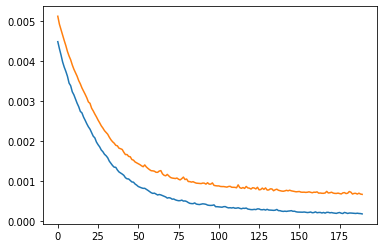

In [16]:
plt.plot(train_loss_history[10:])
plt.plot(test_loss_history[10:])

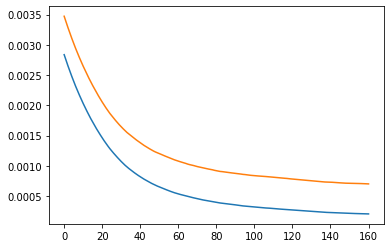

In [17]:
avg_loss_train = moving_average(train_loss_history)
avg_loss_test = moving_average(test_loss_history)
plt.plot(avg_loss_train[10:])
plt.plot(avg_loss_test[10:])

In [18]:
pred = neural_net.forward(X_validation)
pred = pred.data.cpu().numpy()
y_val = Y_validation.data.cpu().numpy()
print('Predicted\nReal value\nDifference\n')

sum_dn1_sq = 0.0
sum_dt1_sq = 0.0
sum_dn1 = 0.0
sum_dt1 = 0.0
sum_dn1_real = 0.0
sum_dt1_real = 0.0
sum_e1 = 0.0
sum_e1_sq = 0.0
sum_e1_real = 0.0

sum_dn2_sq = 0.0
sum_dt2_sq = 0.0
sum_dn2 = 0.0
sum_dt2 = 0.0
sum_dn2_real = 0.0
sum_dt2_real = 0.0
sum_e2 = 0.0
sum_e2_sq = 0.0
sum_e2_real = 0.0

for i in range(300):
    # dt1
    pred[i][1] /= 2.5
    y_val[i][1] /= 2.5
    
    # e1
    pred[i][2] /= 6.3
    y_val[i][2] /= 6.3
    
    # dt2
    #pred[i][3] /= 2.5
    #y_val[i][3] /= 2.5
    
    # e2
    #pred[i][5] /= 6.3
    #y_val[i][5] /= 6.3
    
    dif = abs(pred[i]-y_val[i])
    print(pred[i],'\n',y_val[i],'\n',abs(pred[i]-y_val[i]),'\n')
    
    sum_dn1_sq += dif[0]**2
    sum_dt1_sq += dif[1]**2
    sum_e1_sq += dif[2]**2
    sum_dn1 += dif[0]
    sum_dt1 += dif[1]
    sum_e1 += dif[2]
    #sum_dn2_sq += dif[2]**2
    #sum_dt2_sq += dif[3]**2
    #sum_e2_sq += dif[5]**2
    #sum_dn2 += dif[2]
    #sum_dt2 += dif[3]
    #sum_e2 += dif[5]
    
    sum_dn1_real += y_val[i][0]
    sum_dt1_real += y_val[i][1]
    sum_e1_real += y_val[i][2]
    #sum_dn2_real += y_val[i][2]
    #sum_dt2_real += y_val[i][3]
    #sum_e2_real += y_val[i][5]
    
mean_dn1 = sum_dn1/300
mean_dt1 = sum_dt1/300
mean_e1 = sum_e1/300
mean_dn1_sq = sum_dn1_sq/300
mean_dt1_sq = sum_dt1_sq/300
mean_e1_sq = sum_e1_sq/300
relative_dn1 = sum_dn1/sum_dn1_real
relative_dt1 = sum_dt1/sum_dt1_real
relative_e1 = sum_e1/sum_e1_real
"""
mean_dn2 = sum_dn2/300
mean_dt2 = sum_dt2/300
mean_e2 = sum_e2/300
mean_dn2_sq = sum_dn2_sq/300
mean_dt2_sq = sum_dt2_sq/300
mean_e2_sq = sum_e2_sq/300
relative_dn2 = sum_dn2/sum_dn2_real
relative_dt2 = sum_dt2/sum_dt2_real
relative_e2 = sum_e2/sum_e2_real
"""

Predicted
Real value
Difference

[0.04551761 0.09351505 0.00704949] 
 [0.05739814 0.18541272 0.00908299] 
 [0.01188053 0.09189767 0.0020335 ] 

[0.12187547 0.02630506 0.01655552] 
 [0.14326808 0.0504863  0.0226715 ] 
 [0.02139261 0.02418124 0.00611598] 

[0.38201112 0.12999809 0.05948746] 
 [0.38801473 0.13673267 0.06140151] 
 [0.00600362 0.00673458 0.00191405] 

[0.50312614 0.17815039 0.079395  ] 
 [0.4949551  0.17441742 0.07832433] 
 [0.00817105 0.00373296 0.00107068] 

[0.14337984 0.04231836 0.02069259] 
 [0.13789359 0.04859238 0.02182101] 
 [0.00548625 0.00627401 0.00112842] 

[0.11981811 0.04406575 0.01863204] 
 [0.11267845 0.0397068  0.01783084] 
 [0.00713966 0.00435895 0.0008012 ] 

[0.05259866 0.08412983 0.00827425] 
 [0.05206763 0.11454269 0.00823946] 
 [5.3102523e-04 3.0412860e-02 3.4787692e-05] 

[0.24441569 0.08452804 0.03870798] 
 [0.24150485 0.08510399 0.03821701] 
 [0.00291084 0.00057594 0.00049097] 

[0.04733258 0.0816751  0.00380926] 
 [0.01217017 0.02443651 0.00192587


[0.06702003 0.1315546  0.01115726] 
 [0.08031958 0.04709388 0.0127102 ] 
 [0.01329955 0.08446072 0.00155294] 

[0.0704561  0.02265989 0.01251825] 
 [0.08031547 0.01313556 0.01270955] 
 [0.00985938 0.00952433 0.0001913 ] 

[0.5900985  0.20723471 0.09288756] 
 [0.58325016 0.20553175 0.0922966 ] 
 [0.00684834 0.00170296 0.00059096] 

[0.33295172 0.12290361 0.06339688] 
 [0.20922175 0.07372773 0.03310836] 
 [0.12372997 0.04917587 0.03028852] 

[0.40410817 0.13750425 0.06164438] 
 [0.40197957 0.14165375 0.06361138] 
 [0.0021286 0.0041495 0.001967 ] 

[0.16750419 0.05602016 0.02731135] 
 [0.16985492 0.05985525 0.02687875] 
 [0.00235073 0.00383509 0.0004326 ] 

[0.5979062 0.2111435 0.094464 ] 
 [0.5925186  0.20879786 0.09376329] 
 [0.00538754 0.00234564 0.0007007 ] 

[0.47850913 0.1692249  0.07555073] 
 [0.44950888 0.1584026  0.07113267] 
 [0.02900025 0.0108223  0.00441806] 

[0.22879285 0.08868051 0.03696114] 
 [0.23121746 0.08147881 0.03658908] 
 [0.00242461 0.0072017  0.00037206] 

[0.127

'\nmean_dn2 = sum_dn2/300\nmean_dt2 = sum_dt2/300\nmean_e2 = sum_e2/300\nmean_dn2_sq = sum_dn2_sq/300\nmean_dt2_sq = sum_dt2_sq/300\nmean_e2_sq = sum_e2_sq/300\nrelative_dn2 = sum_dn2/sum_dn2_real\nrelative_dt2 = sum_dt2/sum_dt2_real\nrelative_e2 = sum_e2/sum_e2_real\n'

In [19]:
print('Dn1 mean: ', mean_dn1)
print('Dt1 mean: ', mean_dt1)
print('e1 mean: ', mean_e1)
#print('Dn2 mean: ', mean_dn2)
#print('Dt2 mean: ', mean_dt2)
#print('e2 mean: ', mean_e2)
print('Dn1 MSE: ', math.sqrt(mean_dn1_sq))
print('Dt1 MSE: ', math.sqrt(mean_dt1_sq))
print('e1 MSE: ', math.sqrt(mean_e1_sq))
#print('Dn2 MSE: ', math.sqrt(mean_dn2_sq))
#print('Dt2 MSE: ', math.sqrt(mean_dt2_sq))
#print('e2 MSE: ', math.sqrt(mean_e2_sq))
print('Dn1 Relative: ', relative_dn1)
print('Dt1 Relative: ', relative_dt1)
print('e1 Relative: ', relative_e1)
#print('Dn2 Relative: ', relative_dn2)
#print('Dt2 Relative: ', relative_dt2)
#print('e2 Relative: ', relative_e2)

Dn1 mean:  0.007990455540517966
Dt1 mean:  0.007033813986927271
e1 mean:  0.0013129781687166542
Dn1 MSE:  0.012975636106926244
Dt1 MSE:  0.015964986606097655
e1 MSE:  0.002491212326159012
Dn1 Relative:  0.026256243587096537
Dt1 Relative:  0.05727706870857527
e1 Relative:  0.027263882757828657


In [ ]:
# проверим как предсказанные значения связаны с аналитической формулой
Vs = 2750
Vp = 5000
g = (Vs**2)/(Vp**2)
print('e1 (crack density)\tDn1 formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][2]
    formula = 4*e_pred/(3*g*(1-g))
    dn_pred = pred[i][0]
    dif = abs(dn_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dn_pred,'\t',dif)

In [ ]:
print('Mean difference between predicted value and formula for Dn1: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dn1: ', sum_dif/abs(sum_dn1_real))

In [ ]:
# проверим как предсказанные значения связаны с аналитической формулой
print('e2 (crack density)\tDn2 formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][5]
    formula = 4*e_pred/(3*g*(1-g))
    dn_pred = pred[i][2]
    dif = abs(dn_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dn_pred,'\t',dif)

In [ ]:
print('Mean difference between predicted value and formula for Dn2: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dn2: ', sum_dif/abs(sum_dn2_real))

In [ ]:
print('e1 (crack density)\tDt1 formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][4]
    formula = 16*e_pred/(3*(3-2*g))
    dt_pred = pred[i][1]
    dif = abs(dt_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dt_pred,'\t',dif)

In [ ]:
print('Mean difference between predicted value and formula for Dt1: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dt1: ', sum_dif/abs(sum_dt1_real))

In [ ]:
print('e2 (crack density)\tDt2 formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][5]
    formula = 16*e_pred/(3*(3-2*g))
    dt_pred = pred[i][3]
    dif = abs(dt_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dt_pred,'\t',dif)

In [ ]:
print('Mean difference between predicted value and formula for Dt2: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dt2: ', sum_dif/abs(sum_dt_real))